In [0]:
# import xgboost 
import pandas as pd
import numpy as np
import re
from dateutil.relativedelta import relativedelta

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [66]:
!ls "/content/drive/My Drive/loan_prediction"

'Data Dictionary.xlsx'	     predicted_train.pkl      submission.pkl   xgb2.csv
 feature_importance.csv      sample_submission1.csv   test.csv
 feature_importance.gsheet   sample_submission.csv    train.csv


In [0]:
df= pd.read_csv("/content/drive/My Drive/loan_prediction/train.csv", encoding = "utf-8")
df2= pd.read_csv("/content/drive/My Drive/loan_prediction/test.csv", encoding = "utf-8")
df=df.replace(np.nan, 0 ,regex=True)
df2['loan_default']=[np.nan]*len(df2)

#df.shape
#df2.shape

In [5]:
dataset = pd.concat(objs=[df, df2], axis=0,sort=False).reset_index(drop=True)
dataset.shape

(345546, 41)

In [182]:
dataset['pin']=[str(s).rjust(2,'0')+str(c).rjust(4,'0') for (s,c) in zip(dataset.State_ID, dataset.Current_pincode_ID)]
dataset['pin_f4'] = [k[:-2] for k in dataset['pin']]
dataset[['pin','pin_f4']].head()

,pin,pin_f4
0,061441,0614
1,061502,0615
2,061497,0614
3,061501,0615
4,061495,0614


In [183]:
group_cns  = dataset.groupby(['pin_f4','branch_id']).agg({'PERFORM_CNS.SCORE': ['mean']})
group_cns.columns = ["_".join(x) for x in group_cns.columns.ravel()]
group_cns= group_cns.reset_index()
group_cns.head()
dataset = pd.merge(dataset, group_cns,  how='left', left_on=['pin_f4','branch_id'], right_on = ['pin_f4','branch_id'])
dataset['PERFORM_CNS.SCORE_modified'] = np.where(dataset['PERFORM_CNS.SCORE']>=300, dataset['PERFORM_CNS.SCORE'], dataset['PERFORM_CNS.SCORE_mean'])
dataset['PERFORM_CNS.SCORE_flag'] = np.where(dataset['PERFORM_CNS.SCORE']>=300, 1, 0)
dataset.drop(["PERFORM_CNS.SCORE.DESCRIPTION","PERFORM_CNS.SCORE",'PERFORM_CNS.SCORE_mean'],1,inplace=True)
dataset.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,pin,pin_f4,PERFORM_CNS.SCORE_modified,PERFORM_CNS.SCORE_flag
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,...,0,0,0yrs 0mon,0yrs 0mon,0,0.0,061441,0614,320.942787,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,...,0,1,1yrs 11mon,1yrs 11mon,0,1.0,061502,0615,598.000000,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,...,0,0,0yrs 0mon,0yrs 0mon,0,0.0,061497,0614,320.942787,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,...,0,0,0yrs 8mon,1yrs 3mon,1,1.0,061501,0615,305.000000,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,...,0,0,0yrs 0mon,0yrs 0mon,1,1.0,061495,0614,320.942787,0


In [0]:
# dataset.drop(["PERFORM_CNS.SCORE.DESCRIPTION","PERFORM_CNS.SCORE"],1,inplace=True)

In [0]:
# dataset['pin'].unique().shape

In [0]:
# dataset=dataset.replace(np.nan, 0 ,regex=True)
# dataset.head()


In [186]:
group_b_m = dataset.groupby(['branch_id','manufacturer_id']).agg({'ltv': ['mean', 'median'], 'loan_default': ['sum','mean']})
group_b_m = group_b_m.reset_index()
group_b_m.columns = ["_b_m_".join(x) for x in group_b_m.columns.ravel()]
dataset = pd.merge(dataset, group_b_m,  how='left', left_on=['branch_id','manufacturer_id'], right_on = ['branch_id_b_m_','manufacturer_id_b_m_'])
dataset.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,pin,pin_f4,PERFORM_CNS.SCORE_modified,PERFORM_CNS.SCORE_flag,branch_id_b_m_,manufacturer_id_b_m_,ltv_b_m_mean,ltv_b_m_median,loan_default_b_m_sum,loan_default_b_m_mean
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,...,061441,0614,320.942787,0,67,45,78.467123,81.07,859.0,0.206988
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,...,061502,0615,598.000000,1,67,45,78.467123,81.07,859.0,0.206988
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,...,061497,0614,320.942787,0,67,45,78.467123,81.07,859.0,0.206988
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,...,061501,0615,305.000000,1,67,45,78.467123,81.07,859.0,0.206988
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,...,061495,0614,320.942787,0,67,45,78.467123,81.07,859.0,0.206988


In [0]:
group_branch = dataset.groupby('branch_id').agg({'ltv': ['mean', 'median'], 'loan_default': ['sum','mean'], 'supplier_id':['count'], 'UniqueID':['count']})
group_branch.columns = ["_branch_".join(x) for x in group_branch.columns.ravel()]
group_branch= group_branch.reset_index()
dataset = pd.merge(dataset, group_branch,  how='left', left_on=['branch_id'], right_on = ['branch_id'])

In [0]:
group_manuf = dataset.groupby('manufacturer_id').agg({'supplier_id': ['count'], 'loan_default': ['sum','mean'], 'branch_id':['count'], 'UniqueID':['count']})
group_manuf.columns = ["_manuf_".join(x) for x in group_manuf.columns.ravel()]
group_manuf= group_manuf.reset_index()
dataset = pd.merge(dataset, group_manuf,  how='left', left_on=['manufacturer_id'], right_on = ['manufacturer_id'])

In [0]:
group_pin = dataset.groupby('pin').agg({'supplier_id': ['count'], 'loan_default': ['sum','mean'], 'branch_id':['count'], 'UniqueID':['count']})
group_pin.columns = ["_pin_".join(x) for x in group_pin.columns.ravel()]
group_pin= group_pin.reset_index()
dataset = pd.merge(dataset, group_pin,  how='left', left_on=['pin'], right_on = ['pin'])

In [0]:
group_pin_f4 = dataset.groupby('pin_f4').agg({'supplier_id': ['count'], 'loan_default': ['sum','mean'], 'branch_id':['count'], 'UniqueID':['count']})
group_pin_f4.columns = ["_pin_f4_".join(x) for x in group_pin_f4.columns.ravel()]
group_pin_f4= group_pin_f4.reset_index()
dataset = pd.merge(dataset, group_pin_f4,  how='left', left_on=['pin_f4'], right_on = ['pin_f4'])

In [0]:
# df2=df2.replace(np.nan, 0 ,regex=True)
# df2.tail()


In [0]:
# train_objs_num = len(df)
# dataset = pd.concat(objs=[df, df2], axis=0,sort=False).reset_index(drop=True)

In [0]:
def f(end):
    r = relativedelta(pd.to_datetime('now'), end) 
    return r.years



In [0]:
dataset[['A_Year', 'A_Month']] = dataset['AVERAGE.ACCT.AGE'].str.extractall('(\d+)').unstack().loc[:,0]
dataset[['H_Year', 'H_Month']] = dataset['CREDIT.HISTORY.LENGTH'].str.extractall('(\d+)').unstack().loc[:,0]
dataset['A_Month'] =dataset['A_Year'].astype(np.int64)*12 + dataset['A_Month'].astype(np.int64)
dataset['H_Month'] =dataset['H_Year'].astype(np.int64)*12 + dataset['H_Month'].astype(np.int64)

dataset['ltv_to_asset_cost_ratio']=dataset['ltv']/dataset['asset_cost']

dataset['Date.of.Birth']=pd.to_datetime(dataset['Date.of.Birth'])

def f(end):
    r = relativedelta(pd.to_datetime('now'), end) 
    return r.years

dataset['Age_tillNow'] = dataset["Date.of.Birth"].apply(f)
dataset['Age_tillDisbursal'] = (pd.to_datetime(dataset['DisbursalDate'])-pd.to_datetime(dataset["Date.of.Birth"])).astype('timedelta64[M]')/12


dataset= pd.get_dummies(dataset, columns=["Employment.Type"])

# dataset= pd.get_dummies(dataset, columns=["PERFORM_CNS.SCORE.DESCRIPTION"])


list = ['Date.of.Birth','A_Year','H_Year','AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH','DisbursalDate']


dataset['Tot.Inst'] = dataset['PRIMARY.INSTAL.AMT']+dataset['SEC.INSTAL.AMT']
dataset['Tot.Amt.Sct'] = dataset['PRI.SANCTIONED.AMOUNT']+dataset['SEC.SANCTIONED.AMOUNT']
dataset['Tot.Amt.Dst'] = dataset['PRI.DISBURSED.AMOUNT']+dataset['SEC.DISBURSED.AMOUNT']
dataset['Tot.Loans'] = dataset['PRI.NO.OF.ACCTS']+dataset['SEC.NO.OF.ACCTS']
dataset['Tot.Act.Loans'] = dataset['PRI.ACTIVE.ACCTS']+dataset['SEC.ACTIVE.ACCTS']
dataset['Tot.Due.Loans'] = dataset['PRI.OVERDUE.ACCTS']+dataset['SEC.OVERDUE.ACCTS']
dataset['Kyc_flag'] = dataset['Aadhar_flag']+dataset['Driving_flag']+dataset['MobileNo_Avl_Flag']+dataset['PAN_flag']+dataset['Passport_flag']+dataset['VoterID_flag']
dataset['Tot.Outsanding.Amt'] = dataset['PRI.CURRENT.BALANCE']+dataset['SEC.CURRENT.BALANCE']


dataset = dataset.drop(axis=1, labels=list)
# dataset.columns.get_loc("loan_default")

In [0]:
train = dataset[:len(df)]
test = dataset[len(df):]
train.to_csv('/content/drive/My Drive/loan_prediction/train_dataset.csv',index=False)
test.to_csv('/content/drive/My Drive/loan_prediction/test_dataset.csv',index=False)

In [0]:
# dataset.columns.to_list() 
cols_to_drop = ['UniqueID','branch_id','supplier_id','manufacturer_id','Current_pincode_ID','Employee_code_ID','pin',
                'branch_id_b_m_','manufacturer_id_b_m_']

#'loan_default_pin_mean'


dataset.drop(cols_to_drop,1,inplace=True)


In [37]:
 dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 345546 entries, 0 to 345545
Data columns (total 72 columns):
disbursed_amount                       345546 non-null int64
asset_cost                             345546 non-null int64
ltv                                    345546 non-null float64
State_ID                               345546 non-null category
MobileNo_Avl_Flag                      345546 non-null int64
Aadhar_flag                            345546 non-null int64
PAN_flag                               345546 non-null int64
VoterID_flag                           345546 non-null int64
Driving_flag                           345546 non-null int64
Passport_flag                          345546 non-null int64
PRI.NO.OF.ACCTS                        345546 non-null int64
PRI.ACTIVE.ACCTS                       345546 non-null int64
PRI.OVERDUE.ACCTS                      345546 non-null int64
PRI.CURRENT.BALANCE                    345546 non-null int64
PRI.SANCTIONED.AMOUNT         

In [0]:
dataset['State_ID'] =dataset['State_ID'].astype('category',copy=False)
dataset['pin_f4'] =dataset['pin_f4'].astype('int64',copy=False)
dataset['Employment.Type_0'] =dataset['Employment.Type_0'].astype('category',copy=False)
dataset['Employment.Type_Salaried'] =dataset['Employment.Type_Salaried'].astype('category',copy=False)
dataset['Employment.Type_Self employed'] =dataset['Employment.Type_Self employed'].astype('category',copy=False)

In [0]:
df = dataset[:len(df)]
df2 = dataset[len(df):]

In [0]:
#df.to_pickle('train.pkl')
#df2.to_pickle('test.pkl')
df_ = pd.DataFrame()
df_.to_pickle('/content/drive/My Drive/loan_prediction/submission.pkl')
df_.to_pickle('/content/drive/My Drive/loan_prediction/predicted_train.pkl')



In [0]:
#import pandas_profiling
#pandas_profiling.ProfileReport(dataset)


In [0]:
# dataset= dataset.apply(pd.to_numeric)

In [0]:
#  df['AVERAGE.ACCT.AGE'].str.findall('\d+')

In [0]:
# pd.read_pickle('train.pkl').head()

,disbursed_amount,asset_cost,ltv,State_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,...,Employment.Type_Salaried,Employment.Type_Self employed,Tot.Inst,Tot.Amt.Sct,Tot.Amt.Dst,Tot.Loans,Tot.Act.Loans,Tot.Due.Loans,Kyc_flag,Tot.Outsanding.Amt
0,50578,58400,89.55,6,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,2,0
1,47145,65550,73.23,6,1,1,0,0,0,0,...,0,1,1991,50200,50200,1,1,1,2,27600
2,53278,61360,89.63,6,1,1,0,0,0,0,...,0,1,0,0,0,0,0,0,2,0
3,57513,66113,88.48,6,1,1,0,0,0,0,...,0,1,31,0,0,3,0,0,2,0
4,52378,60300,88.39,6,1,1,0,0,0,0,...,0,1,0,0,0,0,0,0,2,0


In [0]:
x_ = df.drop(axis=1, labels =["loan_default"])
y_=df['loan_default']

xtest_ = df2.drop(axis=1, labels =["loan_default"])

#Y=Y.to_frame()
#list_id = ['Current_pincode_ID','UniqueID','manufacturer_id','State_ID','branch_id','supplier_id','Employee_code_ID']
#X = X.drop(axis=1, labels=list_id)
#df2_2 = df2_2.drop(axis=1, labels=list_id)

In [132]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

num_col = x_.select_dtypes(include=numerics).columns

print('number of numerical columns ',len(num_col))
print('x.shape ',x_.shape )
num_col

number of numerical columns  18
x.shape  (233154, 71)


Index(['ltv', 'PERFORM_CNS.SCORE_modified', 'ltv_b_m_mean', 'ltv_b_m_median',
       'loan_default_b_m_sum', 'loan_default_b_m_mean', 'ltv_branch_mean',
       'ltv_branch_median', 'loan_default_branch_sum',
       'loan_default_branch_mean', 'loan_default_manuf_sum',
       'loan_default_manuf_mean', 'loan_default_pin_sum',
       'loan_default_pin_mean', 'loan_default_pin_f4_sum',
       'loan_default_pin_f4_mean', 'ltv_to_asset_cost_ratio',
       'Age_tillDisbursal'],
      dtype='object')

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_[num_col] = scaler.fit_transform(x_[num_col])
xtest_[num_col] = scaler.transform(xtest_[num_col])
# xtr, xte, ytr, yte = train_test_split(x, y, test_size=0.2, random_state=42)

In [0]:
def print_scores(clf, xte, yte):
    print ('test score = ',clf.score(xte,yte))
    y_pred=clf.predict(xte)
    print (classification_report(yte, y_pred))
    print ('auroc without prob = ', roc_auc_score(yte, y_pred))
    
    try:
        y_prob_pred=clf.predict_proba(xte)[:,1]
        print ('auroc with prob = ', roc_auc_score(yte, y_prob_pred))
    except:
      pass

def get_colname(df, clf):
    clf_class = type(clf).__name__
    return '{}_{}'.format(clf_class,df.shape[1]+1)


def fit_clf_kfold(clf, k=9, save=True, sample=False, **kwargs):
    folds = StratifiedKFold(n_splits=k, shuffle=True, random_state=3115)
    pred_prob = np.zeros(len(x))
    pred_class = np.zeros(len(x))
    submit_prob = np.zeros(len(xtest))
    submit_class = np.zeros(len(xtest))
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(x, y)):
        print("Fold {}".format(fold_))
        if(sample):
            cnn = RandomUnderSampler()
            print('before ', sorted(Counter(y[trn_idx]).items()))
            xtrain, ytrain = cnn.fit_resample(x[trn_idx], y[trn_idx])
            print('after ', sorted(Counter(ytrain).items()))
            clf.fit(xtrain, ytrain, 
                eval_set = [(x[val_idx], y[val_idx])], 
                early_stopping_rounds=10, 
                **kwargs
               )
        else:
            clf.fit( x[trn_idx], y[trn_idx],  
                eval_set = [(x[val_idx], y[val_idx])], 
                early_stopping_rounds=10, 
                **kwargs
               )
          
        if ("predict_proba" in dir(clf)):
          pred_prob[val_idx] = clf.predict_proba(x[val_idx],ntree_limit=clf.best_ntree_limit)[:,1]
          if(save):
            submit_prob += clf.predict_proba(xtest , 
                                           ntree_limit=clf.best_ntree_limit
                                          )[:,1]/folds.get_n_splits()
        else:
          pred_class[val_idx] = clf.predict(x[val_idx])
          if(save):
            submit_class += clf.predict(xtest)/folds.get_n_splits()
    if(save):
      result = pd.read_pickle('/content/drive/My Drive/loan_prediction/submission.pkl')
      predicted_train = pd.read_pickle('/content/drive/My Drive/loan_prediction/predicted_train.pkl')
      colname = get_colname(result,clf)
      if("predict_proba" in dir(clf)):
        result[colname]=submit_prob
        predicted_train[colname] = pred_prob
    else:
        result[colname]=submit_class
        predicted_train[colname] = pred_class
    result.to_pickle('/content/drive/My Drive/loan_prediction/submission.pkl')
    predicted_train.to_pickle('/content/drive/My Drive/loan_prediction/predicted_train.pkl')
  
    if("predict_proba" in dir(clf)):
        print("CV score: {:<8.5f}".format(roc_auc_score(y, pred_prob)))
    else:
        print (classification_report(y, pred_class))
    return clf, pred_prob, pred_class, submit_prob, submit_class

In [0]:

from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report


In [177]:
%%time
x = np.array(x_)
y = np.array(y_)
xtest = np.array(xtest_)
# xtr, xte, ytr, yte = train_test_split(x, y, test_size=0.25, random_state=42)

scale_pos_weight = round(y[y==0].size/y[y==1].size)


param = {}
param['booster'] = 'gbtree'
param['objective'] = 'binary:logistic'
# param["eval_metric"] = "error"
param['eta'] = 0.005
# param['gamma'] = 0
param['max_depth'] = 4
param['n_estimators']=4000
# param['min_child_weight']=1
# param['max_delta_step'] = 0
param['subsample']= 0.8
#param['colsample_bytree']=0.6
param['colsample_bylevel'] = 0.3
param['silent'] = 1
# param['seed'] = 0
param['scale_pos_weight'] = 3
#param['base_score'] = 0.5
param['tree_method']='gpu_hist'

xgb = XGBClassifier(**param)
# xgb.fit(xtr, ytr, eval_set=[(xtr, ytr), (xte, yte)], eval_metric='auc', verbose=0)
# print('test score = ',xgb.score(xte,yte))
# pp=model.predict_proba(xte)
# print('auroc = ',roc_auc_score(yte, pp[:,1]))
# print_scores(xgb, xte, yte)

xgb=fit_clf_kfold(xgb, save=True, eval_metric='auc', verbose=0 , k=15)



Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
Fold 11
Fold 12
Fold 13
Fold 14
CV score: 0.70445 
CPU times: user 48.8 s, sys: 7.47 s, total: 56.3 s
Wall time: 56.4 s


In [173]:
submit = pd.read_pickle('/content/drive/My Drive/loan_prediction/submission.pkl')
y_pred_3=submit[submit.columns[-1]]
# out=pd.DataFrame(y_pred_3, columns=list('Y'))
y_pred_3.describe(percentiles=[.5,.6,.7,.8,.9,.95])

count    112392.000000
mean          0.420184
std           0.179394
min           0.000604
50%           0.427897
60%           0.476928
70%           0.525008
80%           0.577817
90%           0.645034
95%           0.697967
max           0.969668
Name: XGBClassifier_9, dtype: float64

In [174]:
# pyplot.bar(range(len(xgb[0].feature_importances_)), xgb[0].feature_importances_)
# pyplot.show()
model=xgb[0]
fimp=pd.DataFrame()
fimp['features']=x_.columns.values
#fimp.drop(fimp.index[[59,0]], inplace=True)
fimp['feature_importance']=model.feature_importances_
# fimp.to_csv("/content/drive/My Drive/loan_prediction/feature_importance.csv",sep=',',encoding='utf-8',index=False)
fimp.sort_values(by='feature_importance', ascending=False)


,features,feature_importance
47,loan_default_pin_mean,0.100076
44,UniqueID_manuf_count,0.061878
33,loan_default_b_m_mean,0.054716
2,ltv,0.040462
0,disbursed_amount,0.040239
46,loan_default_pin_sum,0.039335
12,PRI.OVERDUE.ACCTS,0.035345
64,Tot.Amt.Sct,0.028233
14,PRI.SANCTIONED.AMOUNT,0.027716
26,NO.OF_INQUIRIES,0.027511


In [175]:
submit = pd.read_pickle('/content/drive/My Drive/loan_prediction/submission.pkl')
predicted = pd.read_pickle('/content/drive/My Drive/loan_prediction/predicted_train.pkl')
submit.head()

,XGBClassifier_1,XGBClassifier_2,XGBClassifier_3,XGBClassifier_4,XGBClassifier_5,XGBClassifier_6,XGBClassifier_7,XGBClassifier_8,XGBClassifier_9
0,0.551745,0.545465,0.545465,0.564643,0.563776,0.563776,0.553638,0.561098,0.556993
1,0.587459,0.594527,0.594527,0.599572,0.604349,0.604349,0.601009,0.604704,0.608498
2,0.568515,0.566945,0.566945,0.593399,0.590121,0.590121,0.584790,0.576571,0.577307
3,0.432297,0.440790,0.440790,0.467621,0.470306,0.470306,0.452669,0.450646,0.445440
4,0.559724,0.552814,0.552814,0.551310,0.557348,0.557348,0.544291,0.554009,0.546895


In [0]:
df_sub = pd.read_csv('/content/drive/My Drive/loan_prediction/sample_submission.csv')
df_sub['loan_default']=submit['XGBClassifier_7']#[['XGBClassifier_1',	'XGBClassifier_2',	'CatBoostClassifier_3',	'CatBoostClassifier_4']].mean(1)#['XGBClassifier_2']
df_sub.to_csv('/content/drive/My Drive/loan_prediction/xgb11.csv',index=False)

In [0]:
X= X.apply(pd.to_numeric)
df2_2= df2_2.apply(pd.to_numeric)



model=XGBClassifier(
 learning_rate =0.05,
 subsample=0.8,
colsample_bytree=0.6,
 n_estimators=1500,
 max_depth=3,
 min_child_weight=1,
 gamma=5,
 objective= 'binary:logistic',
 nthread=8,
 seed=27)
model.fit(X,Y)

y_pred_3 = model.predict(df2_2)


#out=pd.DataFrame(y_pred_3, columns=list('NY'))
#out.describe(percentiles=[.5,.6,.7,.8,.9,.95])





/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:

#df2.shape
np.count_nonzero(y_pred_3 == 1)
#len(y_pred_3)

#y_pred_3.count("1")

#df.query('education == "9th"').education.count()

444

In [0]:
def cross_val(X_train, y_train, model):
    # Applying k-Fold Cross Validation
    from sklearn.model_selection import cross_val_score
    accuracies = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5)
    return accuracies.mean()

In [0]:
%%time
x = np.array(x_)
y = np.array(y_)
xtest = np.array(xtest_)
# xtr, xte, ytr, yte = train_test_split(x, y, test_size=0.25, random_state=42)

scale_pos_weight = round(y[y==0].size/y[y==1].size)


param = {}
param['booster'] = 'gbtree'
param['objective'] = 'binary:logistic'
# param["eval_metric"] = "error"
# param['eta'] = 0.3
# param['gamma'] = 0
param['max_depth'] = 4
param['n_estimators']=2000
# param['min_child_weight']=1
# param['max_delta_step'] = 0
# param['subsample']= 1
# param['colsample_bytree']=1
param['silent'] = 1
# param['seed'] = 0
param['scale_pos_weight'] = scale_pos_weight
param['base_score'] = 0.3
param['tree_method']='gpu_hist'

xgb = XGBClassifier(**param)
# xgb.fit(xtr, ytr, eval_set=[(xtr, ytr), (xte, yte)], eval_metric='auc', verbose=0)
# print('test score = ',xgb.score(xte,yte))
# pp=model.predict_proba(xte)
# print('auroc = ',roc_auc_score(yte, pp[:,1]))
# print_scores(xgb, xte, yte)


cross_val(X_low, Y_low, model)

[0.01726396 0.02812877 0.00951606 0.0376806  0.01496041 0.01091004
 0.0229496  0.01930945 0.03124245 0.00985394 0.         0.02485145
 0.00853963 0.02739699 0.00516036 0.00554426 0.04997758 0.01690836
 0.0126935  0.0503498  0.00886632 0.02036694 0.01356369 0.00643203
 0.00526071 0.00598476 0.0064719  0.00715746 0.00727006 0.01128673
 0.00632748 0.01179211 0.03501973 0.03904304 0.00789503 0.01631342
 0.01167036 0.01186947 0.03533759 0.02828344 0.00909417 0.00648576
 0.00843543 0.00838487 0.00684292 0.0079934  0.00632314 0.00894935
 0.00784739 0.00719263 0.00899343 0.00717781 0.03952337 0.
 0.         0.01005644 0.0057726  0.00815609 0.00521154 0.00575887
 0.01067442 0.03622304 0.013216   0.01807119 0.01633711 0.01947832
 0.00922627 0.00912503]


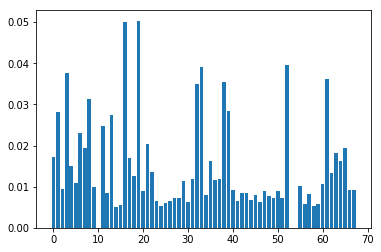

In [0]:
from matplotlib import pyplot
import xgboost as xgb
# feature importance
print(model.feature_importances_)
# plot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

# plot feature importance manually
fimp=pd.DataFrame()
fimp['features']=X.columns.values
#fimp.drop(fimp.index[[59,0]], inplace=True)
fimp['feature_importance']=model.feature_importances_
fimp.to_csv("/content/drive/My Drive/loan_prediction/feature_importance.csv",sep=',',encoding='utf-8',index=False)



In [0]:
x=pd.DataFrame()
arr=df2.UniqueID.values
x['UniqueID']=arr
x['loan_default']= y_pred_3 
x.to_csv("/content/drive/My Drive/loan_prediction/sample_submission2.csv",sep=',',encoding='utf-8',index=False)


In [0]:
y_pred_3 == 1

array([False, False, False, ..., False, False, False])

In [0]:
fd = pd.DataFrame({'a':[1,2,3]})
fd['b']=[2,2,3]
fd['c']=fd['a']/fd['b']
fd

,a,b,c
0,1,2,0.5
1,2,2,1.0
2,3,3,1.0


In [0]:
fd.mean()

a    2.0
b    NaN
dtype: float64

In [0]:
train_low = df[df['PERFORM_CNS.SCORE_modified'] < 500 ]
train_med = df[(df['PERFORM_CNS.SCORE_modified'] >= 500) & (df['PERFORM_CNS.SCORE_modified'] < 700) ]
train_high = df[df['PERFORM_CNS.SCORE_modified'] >= 700]

test_low = df2[df2['PERFORM_CNS.SCORE_modified'] < 500]
test_med = df2[(df2['PERFORM_CNS.SCORE_modified'] >= 500) & (df2['PERFORM_CNS.SCORE_modified'] < 700) ]
test_high = df2[df2['PERFORM_CNS.SCORE_modified'] >= 700]

In [144]:
X_low = train_low.drop(axis=1, labels =["loan_default"])
Y_low= train_low['loan_default']
#Y_low=Y_low.to_frame()
test_low = test_low.drop(axis=1, labels =["loan_default"])

#list_id = ['Current_pincode_ID','UniqueID','manufacturer_id','State_ID','branch_id','supplier_id','Employee_code_ID']
#X_low = X_low.drop(axis=1, labels=list_id)
#test_low_2 = test_low.drop(axis=1, labels=list_id)

X_low= X_low.apply(pd.to_numeric)
test_low_2= test_low.apply(pd.to_numeric)


KeyError: ignored